<a href="https://colab.research.google.com/github/danplotkin/Transformer-based-Image-Captioning-From-Scratch-with-TensorFlow/blob/main/Image_Captioner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Transformers

Transformers have had a huge impact on the world of natural language processing (NLP) in recent times. They're a type of neural network architecture that's been changing the game since their introduction in a 2017 paper by Vaswani et al. The paper, called [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf), highlighted the power of a self-attention mechanism for handling sequential data.

Previously, when dealing with sequential data in NLP, people mostly used recurrent neural networks (RNNs). RNNs handle input data one item at a time and pass hidden state information from one time step to the next. Although they've been successful in many NLP tasks, their sequential nature limits their ability to remember long-term dependencies and makes them slow. But the transformer architecture addresses these limitations by using self-attention. This allows it to consider all the elements in a sequence simultaneously rather than processing them one by one. The self-attention mechanism is also more efficient than RNNs, making it easier to parallelize and scale.

Transformers have shown exceptional results in many NLP tasks like language translation, sentiment analysis, and text classification. They can capture long-range dependencies in the input sequence, which is especially helpful for machine translation tasks where the context of a sentence can affect its meaning. They've even been used in other sequential data tasks like image captioning and music generation. The transformer architecture is versatile and effective, which makes it a popular choice for deep learning researchers and practitioners alike.


# Base Transformer Architecture

Below is an annotated visual of the Transformer model architecture addressed in the original paper that I found from [this informational article](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html):

![image.png](https://lena-voita.github.io/resources/lectures/seq2seq/transformer/model-min.png)

### Attention

As mentioned in the introduction, the main component that differentiates Transformers from RNNs or LSTMs is the attention mechanism. Before we dive into our encoder and decoder architectures, lets looks at how the attention mechanism is calculated. Below is the the formula for attention:

![image.png](https://raw.githubusercontent.com/ldy8665/Material/master/image/Blog/Attention_formula1.png)

Above is the basic attention formula where $K$ and $V$ are the key and value vectors, respectively, $Q$ is the query vector, and $d_k$ is the dimensionality of the key vectors. The Softmax function normalizes the scores so that they sum to one, and the dot product between $Q$ and $K$ measures the similarity between the query and each key.

### Multi-Head Attention

In transformers, we use multi-head attention to allow the model to jointly attend to information from different representation subspaces at different positions. Multi-head attention computes multiple attention weights in parallel using different linear projections of the input. The outputs of these parallel attention computations are concatenated and projected to produce the final attention output. Below is the formula for multi-head attention:

![image.png](https://www.tutorialexample.com/wp-content/uploads/2021/03/Multi-Head-Attention.png)

# Image Captioner Transformer Model Architecture

Now we will talk about the architecture we will be implementing in this model. The architecture I will be using is inspired by the architecture described in [Bornon: Bengali Image Captioning with Transformer-Based Deep Learning Approach](https://www.researchgate.net/publication/354574904_Bornon_Bengali_Image_Captioning_with_Transformer-Based_Deep_Learning_Approach). Below is an image of this architecture:

![Image](https://raw.githubusercontent.com/danplotkin/Transformer-based-Image-Captioning-From-Scratch-with-TensorFlow/main/Illustration-of-the-transformer-based-model-to-caption-image.jpg)



### The Encoder

Unlike in the original sequence-to-sequence model, before inputs are fed into the encoder, each image is ran through an image **feature extractor**, which usually consists of a pre-trained Convolutional Neural Network (CNN). These features are reshaped and fed into a fully connected layer with a ReLU activation to map the depth to the size $d_{model}$.

Our encoder block resemebles the block used in the original paper. The outputs of the ReLU activation are fed into a **global multi-head self-attention layer**. The outputs of this are added to the inputs of this layer, and the sum is normalized with a **layer normalization** layer.

The outputs of the global self-attention layer are input into a two-layer **feed forward** network with a ReLU activation in between the layers. The outputs of the network are added to the inputs of the network, and the sum is normalized with layer normalization. This output is what will be used to input into the decoder block for cross-attention which we will discuss when we talk about the decoder.

In this model we plan to stack multiple encoder blocks on top of each other. This means the outputs of the feed forward network will be passed as inputs to the next enoder block for $N$ times. The reason we do this is to allow the model to attend to different parts of the image and learn meaningful representations that can be used to generate captions.

### The Decoder

The decoder is similar to a standard Transformer decoder layout with stacked attention mechanisms. Before text is input into the decoder, it is input into an **positional embedding** layer. The layer takes as input a sequence of integer tokens, which represent words or subwords in a sentence, and returns a sequence of vectors that represent the embedding of each token and its position in the sequence. We mask all of the tokens that are padded zeros so are model can only learn tokens that represent tokens in the sequence.

The first layer of the decoder is multi-head self-attention layer with a **causal masking** mechanism that ensures the model generates the current word with only the previous word, not any future information. The inputs of the decoder and outputs of the self-attention mechanism are then added together and normalized using a layer normalization layer.

The data is then passed to a **multi-head cross-attention** to learn how to weigh the importance of each visual feature for generating the caption. In this attention mechanism, $Q$ will be the outputs of the causal self-attention layer in the decoder, and $V$ and $K$ will be the outputs of the encoder. The outputs of this layer are then added to the inputs of the layer and normalized with layer normalization.

The outputs are then passed into a feed forward neural network with the last dense layer having the same amount of units as the value of $d_{model}$. The outputs are now added to the inputs of the feed forward network and normalized with layer normalization.

In this model we plan to stack multiple decoder blocks on top of each other. This means the outputs of the feed forward network will be passed as inputs to the next decoder block for $N$ times, while using the same outputs of the encoder block for the cross-attention mechanism. The reason we do this is for our model to learn more complex relationships between the inputs and outputs, as well as prevent overfitting.


### Outputs

The outputs of the decoder are passed through a fully connected layer where the number of units are equal to the size of our vocabulary.

# Import Libraries

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import time
import numpy as np
import pickle
import re
import string
import matplotlib.pyplot as plt
plt.style.use('bmh')
import collections
import opendatasets as od

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import callbacks
from keras.utils import plot_model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import TextVectorization
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
od.download('https://www.kaggle.com/datasets/adityajn105/flickr8k')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: danielplotkin
Your Kaggle Key: ··········


100%|██████████| 1.04G/1.04G [00:11<00:00, 97.6MB/s]


# Define Model Parameters

In [4]:
CAPTIONS_PATH = '/content/flickr8k/captions.txt'
IMAGE_PATH = '/content/flickr8k/Images/'
IMAGE_SIZE = (299, 299, 3)
NUM_LAYERS = 2
BATCH_SIZE = 32
D_MODEL = 512
NUM_HEADS = 8
EPOCHS = 50
DENSE_NODES = D_MODEL * 2
AUTOTUNE = tf.data.experimental.AUTOTUNE
MAX_SEQ_LEN = 50
VOCAB_SIZE = 10000
SOS = '<START>'
EOS = '<END>'

# Load and Map Dataset

Below we will create a function `create_mappings()` that will take our text path, delete images that have very small captions, then map our images to captions in a dictionary.

In [5]:
# function to create dictionary mapping image -> captions
def create_mappings(txt_path):
    # Load in text doc
    with open(txt_path) as f:
        next(f)
        doc = f.read()

    # create dictionary
    mapping = {}
    images_to_delete = []
    for line in doc.split('\n'):
        split = line.split(',')
        if len(split) >= 2:
            # split image with description
            image, description = split[0], split[1]
            image = os.path.join(IMAGE_PATH, image)

            # remove images with small captions
            if len(description.split()) < 5:
                images_to_delete.append(image)

            # add images into dictionary
            if image not in mapping:
                mapping[image] = []
            mapping[image].append(description)

            # delete images that had short captions
            for img in images_to_delete:
                if img in mapping:
                    del mapping[img]

    return mapping


mapping = create_mappings(CAPTIONS_PATH)

# Create Training-Validaton Split

In [6]:
def train_val_mapping_split(mapping, train_size=0.8, shuffle=True):
    image_paths = list(mapping.keys())

    if shuffle:
        np.random.shuffle(image_paths)

    split = int(len(image_paths) * train_size)

    train_list = [(key, mapping[key]) for key in image_paths[:split]]
    valid_list = [(key, mapping[key]) for key in image_paths[split:]]

    return train_list, valid_list

In [7]:
# split into training and valiation sets
train_set_raw, valid_set_raw = train_val_mapping_split(mapping)

In [8]:
print(f'Training Size: {len(train_set_raw)}, Validation Size: {len(valid_set_raw)}')

Training Size: 5681, Validation Size: 1421


In [9]:
train_set_raw[0]

('/content/flickr8k/Images/408233586_f2c1be3ce1.jpg',
 ['A brown and black dog fetching a tennis ball in a lake .',
  'A dog in water with its head cocked to the side looking at a ball .',
  'A dog is running through the water chasing after a ball .',
  'A dog is shaking off water in a lake as a red and green tennis ball floats by .',
  'A dog playing with a ball in water'])

# Preprocess Data

We will be preprocessing our datasets below by creating preprocessing functions and mapping it to our sets.

In [10]:
# get train captions into a list
train_captions = []
for row in [captions for _, captions in train_set_raw]:
    train_captions.extend(row)

# make sure we have all of the train captions
assert(len(train_captions) == len(train_set_raw) * 5)

In [11]:
# create custom standardization
def standardize(s):
    s = tf.strings.lower(s)
    s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
    s = tf.strings.strip(s)
    s = tf.strings.join([SOS, s, EOS], separator=' ')
    return s


# build vectorizer
vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    ragged=True,
    standardize=standardize
)

# fit on to all captions
vectorizer.adapt(train_captions)

In [12]:
vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '<START>', '<END>', 'in', 'the', 'on', 'is', 'and']

In [13]:
vectorizer.vocabulary_size()

7442

Right now our training and validaton sets are mapped 1:5 for images to captions. We will create a function to flatten our set to be mapped 1:1.

In [14]:
def flatten_set(input_list):
    return [(image_path, caption) for image_path, captions in input_list for caption in captions]


train_list = flatten_set(train_set_raw)
valid_list = flatten_set(valid_set_raw)

Now we will split our data into an `(inputs, labels)` format. Our inputs will consist of a tuple of `(images, input_tokens)` and our labels will be `label_tokens`. Our token shape after applying the `vectorizer` to it is `(batch_size, seq_length)`, so we will use the last dimention of our tokens to extract input and label tokens.

In [15]:
def prepare_txt(imgs, txts):
    tokens = vectorizer(txts)

    input_tokens = tokens[..., :-1]
    label_tokens = tokens[..., 1:]
    return (imgs, input_tokens), label_tokens

Now we will create a function to preprocess our image paths into tensors.

In [16]:
def prepare_imgs(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE[:-1])
    img /= 255.
    return img

Now we will combine all of these preprocessing steps into a function.

In [17]:
def apply_preprocessing_steps(flattened_list, buffer_size=5000):
    dataset = tf.data.experimental.from_list(flattened_list).shuffle(buffer_size)
    dataset = dataset.map(lambda imgs, txt: (prepare_imgs(imgs), txt))
    dataset = dataset.map(prepare_txt, AUTOTUNE).padded_batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

In [18]:
# apply preprocessing to each of our datasets
train_ds = apply_preprocessing_steps(train_list)
valid_ds = apply_preprocessing_steps(valid_list)

train_ds.element_spec

((TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [19]:
print(f'Train Batches: {len(train_ds)}, Valid Batches: {len(valid_ds)}')

Train Batches: 888, Valid Batches: 223


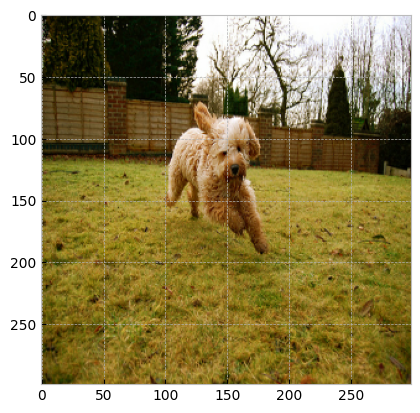

<START> a small brown puddle running through a grassy yard
a small brown puddle running through a grassy yard <END>



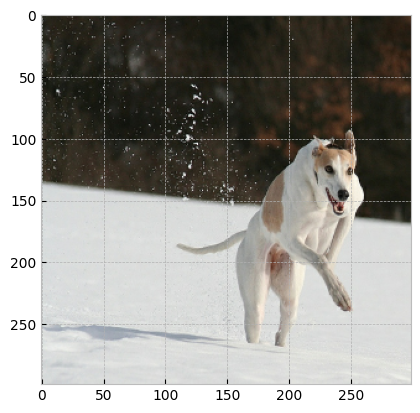

<START> the white and brown dog is running over the surface of the snow
the white and brown dog is running over the surface of the snow <END>



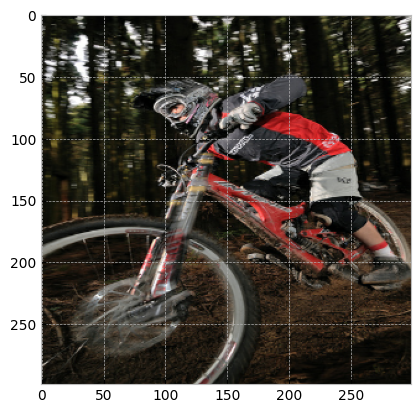

<START> dirt bike rider getting ready to start down the slope
dirt bike rider getting ready to start down the slope <END>



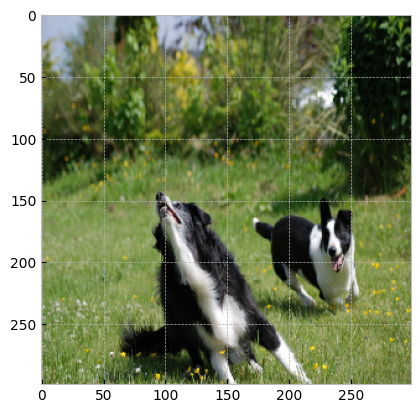

<START> two black and white dogs running in a flowery field
two black and white dogs running in a flowery field <END>



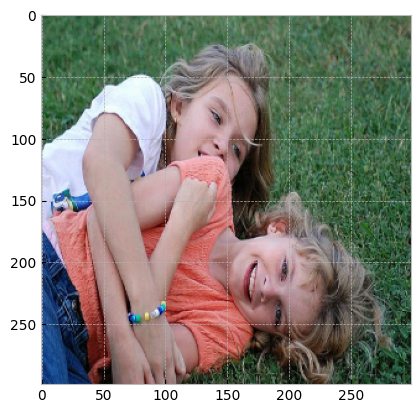

<START> the girl in the white shirt has a bracelet on and has her arm around the girl in the peach shirt
the girl in the white shirt has a bracelet on and has her arm around the girl in the peach shirt <END>



In [20]:
# validate our preprocessing
vocab = vectorizer.get_vocabulary()
for (x, y), z in train_ds.unbatch().take(5):
    in_seq = ' '.join([vocab[token] for token in y if token != 0])
    out_seq = ' '.join([vocab[token] for token in z if token != 0])
    plt.imshow(x)
    plt.show()
    print(in_seq)
    print(out_seq)
    print()

# Build Model

Below we will be implementing a Transformer from scratch using Keras layers.

### Feature Extractor

Below we will create a function to build our feature extractor. We will be using the InceptionV3 pre-trained architecture.

In [21]:
def build_feature_extractor(d_model):
    base_model = InceptionV3(include_top=False, input_shape=IMAGE_SIZE)
    base_model.trainable = False
    base_model_output = base_model.output
    base_model_output = layers.Reshape((-1, base_model_output.shape[-1]))(base_model_output)
    base_model_output = layers.Dense(d_model, activation='relu')(base_model_output)
    cnn_model = Model(base_model.input, base_model_output, name='InceptionV3')
    return cnn_model


build_feature_extractor(D_MODEL).output.shape

87910968/87910968 [==============================] - 0s 0us/step


TensorShape([None, 64, 512])

### Positional Embedding Layer

Below we will create our positional embedding layer to incorporate the positional information of words in each sequence.

In [22]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, vocab_size, max_length, d_model, name=None):
        super().__init__(name=name)
        self.pos_embedding = layers.Embedding(input_dim=max_length, output_dim=d_model)
        self.token_embedding = layers.Embedding(
            input_dim=vocab_size,
            output_dim=d_model
        )
        self.embed_scale = tf.math.sqrt(tf.cast(d_model, tf.float32))

    def call(self, inputs):
        embedded_tokens = self.token_embedding(inputs) * self.embed_scale

        positions = tf.range(tf.shape(inputs)[1])
        positions = positions[tf.newaxis, :]
        embedded_positions = self.pos_embedding(positions)
        return embedded_positions + embedded_tokens

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

### Attention and Feed Forward layers

Below we will create the following layers:

1. `GlobalSelfAttention` - Attention mechanism used at the input of the encoder with no mask.

2. `CausalSelfAttention` - Attention mechanism used as the input of the decoder with a causal masking mechanism.

3. `CrossAttention` - Attention mechanism used to join and learn relationships between the decoder and encoder.

4. `FeedForward` - Feed forward network used in both the encoder and decoder.

In [23]:
class GlobalSelfAttention(layers.Layer):
    def __init__(self, d_model, num_heads, name=None, dropout_rate=0.1):
        super().__init__(name=name)
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model//num_heads,
            dropout=dropout_rate
        )
        self.layerNorm = layers.LayerNormalization()
        self.linear_transform = layers.Dense(d_model)
        self.add = layers.Add()

    def call(self, x, training=True):
        attention_output = self.attention(
            query=x,
            key=x,
            value=x,
            training=training
        )
        selfAttentionOut = self.add([x, attention_output])
        return self.layerNorm(selfAttentionOut)


class CausalSelfAttention(layers.Layer):
    def __init__(self, d_model, num_heads, name=None, dropout_rate=0.1):
        super().__init__(name=name)
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model//num_heads,
            dropout=dropout_rate
        )
        self.layerNorm = layers.LayerNormalization()
        self.add = layers.Add()

    def call(self, x, training=True):
        attention_output = self.attention(
            query=x,
            key=x,
            value=x,
            use_causal_mask=True,
            training=training,
        )
        selfAttentionOut = self.add([x, attention_output])
        return self.layerNorm(selfAttentionOut)


class CrossAttention(layers.Layer):
    def __init__(self, d_model, num_heads, name=None, dropout_rate=0.1):
        super().__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        self.dropout_rate = dropout_rate
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model//num_heads,
            dropout=dropout_rate
        )
        self.layerNorm = layers.LayerNormalization()
        self.dropout = layers.Dropout(dropout_rate)
        self.add = layers.Add()

    def call(self, x, y, training=True):
        attention_output = self.attention(
            query=x,
            key=y,
            value=y,
            training=training
        )
        crossAttentionOut = self.add([x, attention_output])
        crossAttentionOut = self.layerNorm(crossAttentionOut)

        return crossAttentionOut


class FeedForward(layers.Layer):
    def __init__(self, dense_units, d_model, name=None, dropout_rate=0.1):
        super().__init__(name=name)
        self.ff = Sequential(
            [
                layers.Dense(dense_units, activation='relu'),
                layers.Dropout(dropout_rate),
                layers.Dense(d_model),
                layers.Dropout(dropout_rate)
            ]
        )
        self.layerNorm = layers.LayerNormalization()
        self.add = layers.Add()

    def call(self, x, training=True):
        ff_output = self.ff(x, training=training)
        feedForwardOut = self.add([x, ff_output])
        return self.layerNorm(feedForwardOut)

### Encoder and Decoder Blocks

Now we will build our encoder and decoder blocks using the layers built above.

In [24]:
class EncoderBlock(layers.Layer):
    def __init__(self, dense_units, num_heads, d_model, name=None, dropout_rate=0.1):
        super().__init__(name=name)
        self.self_attention = GlobalSelfAttention(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate
        )
        self.ff = FeedForward(
            dense_units=dense_units,
            d_model=d_model,
            dropout_rate=dropout_rate
        )

    def call(self, x, training=True):
        self_attention_out = self.self_attention(x, training=training)
        feed_forward_out = self.ff(self_attention_out, training=training)
        return feed_forward_out

    def get_config(self):
        config = super().get_config()
        return config


class DecoderBlock(layers.Layer):
    def __init__(self, dense_units, num_heads, d_model, name=None, dropout_rate=0.1):
        super().__init__(name=name)
        self.self_attention = CausalSelfAttention(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate
        )
        self.cross_attention = CrossAttention(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate
        )
        self.ff = FeedForward(
            dense_units=dense_units,
            d_model=d_model,
            dropout_rate=dropout_rate
        )

    def call(self, x, encoder_output, training=True):
        self_attention_out = self.self_attention(x, training=training)
        cross_attention_out = self.cross_attention(
            self_attention_out,
            encoder_output,
            training=training
        )
        feed_forward_out = self.ff(cross_attention_out, training=training)
        return feed_forward_out

### Implement Transformer

Below we will build our Transformer class.

In [25]:
class Transformer(Model):
    def __init__(self, num_layers, vocab_size, max_length,
                 dense_units, num_heads, d_model, dropout_rate=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.feature_extractor = build_feature_extractor(d_model)
        self.num_layers = num_layers
        self.positional_embedding = PositionalEmbedding(vocab_size,
                                                        max_length,
                                                        d_model,
                                                        name='PositionalEmbedding')
        self.encoder_layers = [
            EncoderBlock(
                dense_units, num_heads, d_model, name='EncoderBlock', dropout_rate=dropout_rate
            ) for n in range(num_layers)
        ]
        self.decoder_layers = [
            DecoderBlock(
                dense_units, num_heads, d_model, name='DecoderBlock', dropout_rate=dropout_rate
            ) for n in range(num_layers)
        ]
        self.output_layer = layers.Dense(vocab_size, name='Output')

    def call(self, inputs, training):
        images, text = inputs

        # extract image features
        images = self.feature_extractor(images)

        # positional encoding for decoder
        text = self.positional_embedding(text)

        # encoding stage
        for enc_layer in self.encoder_layers:
            images = enc_layer(images, training=training)

        # decoding stage
        for dec_layer in self.decoder_layers:
            text = dec_layer(text, images, training=training)

        # output
        output = self.output_layer(text)
        return output

### Initialize Model

In [26]:
model = Transformer(
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    vocab_size=vectorizer.vocabulary_size(),
    max_length=MAX_SEQ_LEN,
    dense_units=DENSE_NODES,
    d_model=D_MODEL
)

# Train Model

Below we will prepare and train our model.

### Loss and Accuracy Functions

We will create our `masked_loss` and `masked_accuracy` functions that make use of a boolean mask that is True for valid time steps and False for padded time steps.

In [27]:
def masked_loss(labels, preds):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

    mask = (labels != 0) & (loss < 1e8)
    mask = tf.cast(mask, loss.dtype)

    loss = loss*mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_acc(labels, preds):
    mask = tf.cast(labels!=0, tf.float32)
    preds = tf.argmax(preds, axis=-1)
    labels = tf.cast(labels, tf.int64)
    match = tf.cast(preds == labels, mask.dtype)
    acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
    return acc

### Learning Rate Schedule

We will create a custom learning rate schedule based on the formula used in the original paper:

$$\Large{lrate = d_{model}^{-0.5} \cdot \min(\text{step}_{\text{num}}^{-0.5}, \text{step}_{\text{num}} \cdot \text{warmup}_{\text{steps}}^{-1.5})}$$

Why do we do this? Using a fixed learning rate throughout the training process can be suboptimal. In the early stages of training, when the model parameters are far from their optimal values, a high learning rate can help the model converge more quickly. However, as training progresses and the model gets closer to the optimal parameters, a high learning rate can cause the model to overshoot the optimal values and diverge. A learning rate schedule helps address this problem by reducing the learning rate over time. We will add a scale factor to our formula so the initial learning rate is not too high.

In [28]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=2500, scale_factor=0.1):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        self.scale_factor = scale_factor

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)

        arg2 = step * (self.warmup_steps ** -1.5)

        lr = self.scale_factor * tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        return lr

    def get_config(self):
        return {
            'd_model': self.d_model.numpy(),
            'warmup_steps': self.warmup_steps,
            'scale_factor': self.scale_factor
        }

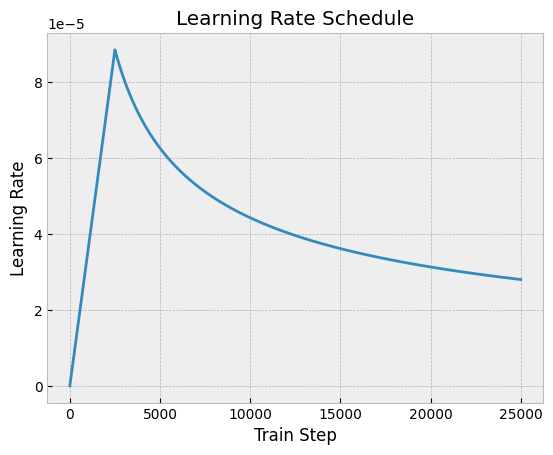

In [29]:
learning_rate = CustomSchedule(D_MODEL)
optimizer = Adam(learning_rate)

plt.plot(learning_rate(tf.range(25000, dtype=tf.float32)))
plt.title('Learning Rate Schedule')
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

### Compile and Train Model

In [30]:
loss_fn = masked_loss
metrics = [masked_acc]
early_stopping = callbacks.EarlyStopping(patience=8, restore_best_weights=True)
weights_path = '/content/drive/MyDrive/Models/Image_Captioner_Weights'
checkpoint = callbacks.ModelCheckpoint(
    weights_path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min'
)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=[metrics])

Now we will train our model onto our training dataset.

In [31]:
history = model.fit(
    train_ds.repeat(),
    validation_data=valid_ds.repeat(),
    steps_per_epoch=500,
    validation_steps=100,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50
500/500 [==============================] - 146s 247ms/step - loss: 7.3250 - masked_acc: 0.1234 - val_loss: 5.5762 - val_masked_acc: 0.2064
Epoch 2/50
500/500 [==============================] - 131s 262ms/step - loss: 4.9257 - masked_acc: 0.2489 - val_loss: 4.4037 - val_masked_acc: 0.2851
Epoch 3/50
500/500 [==============================] - 118s 236ms/step - loss: 4.1521 - masked_acc: 0.3084 - val_loss: 3.8672 - val_masked_acc: 0.3370
Epoch 4/50
500/500 [==============================] - 117s 233ms/step - loss: 3.7329 - masked_acc: 0.3422 - val_loss: 3.6033 - val_masked_acc: 0.3561
Epoch 5/50
500/500 [==============================] - 117s 235ms/step - loss: 3.4105 - masked_acc: 0.3676 - val_loss: 3.3603 - val_masked_acc: 0.3778
Epoch 6/50
500/500 [==============================] - 120s 241ms/step - loss: 3.1533 - masked_acc: 0.3921 - val_loss: 3.2187 - val_masked_acc: 0.3870
Epoch 7/50
500/500 [==============================] - 122s 243ms/step - loss: 2.9711 - masked_acc: 0

In [32]:
model.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InceptionV3 (Functional)    (None, 64, 512)           22851872  
                                                                 
 PositionalEmbedding (Positi  multiple                 3835904   
 onalEmbedding)                                                  
                                                                 
 EncoderBlock (EncoderBlock)  multiple                 2102784   
                                                                 
 EncoderBlock (EncoderBlock)  multiple                 2102784   
                                                                 
 DecoderBlock (DecoderBlock)  multiple                 3154432   
                                                                 
 DecoderBlock (DecoderBlock)  multiple                 3154432   
                                                       

In [33]:
model.load_weights(weights_path)

### Evaluate Training

In [34]:
_ = model.evaluate(valid_ds, steps=100)

100/100 [==============================] - 19s 168ms/step - loss: 3.0677 - masked_acc: 0.4055


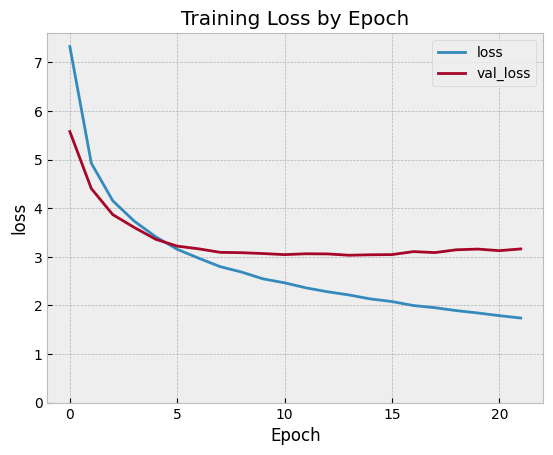

In [35]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training Loss by Epoch')
plt.legend()
plt.show()

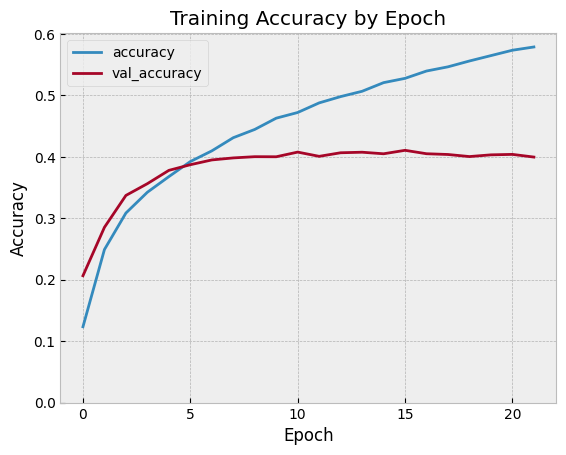

In [36]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy by Epoch')
plt.legend()
plt.show()

# Generate Captions

We will define the function `generate_text()` that will generate a caption when given an image path. The `temperature` parameter represents how robust and diverse our captions are. The higher the temperature, the more diverse the captions are.

In [37]:
def generate_text(img, max_length=MAX_SEQ_LEN, temperature=0):
    word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=vectorizer.get_vocabulary()
    )

    index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=vectorizer.get_vocabulary(),
        invert=True
    )

    img = prepare_imgs(img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img = tf.expand_dims(img, axis=0)
    initial = word_to_index([[SOS]])

    tokens = initial
    for n in range(max_length):
        preds = model((img, tokens), training=False).numpy()
        preds = preds[:,-1, :]
        if temperature==0:
            next = tf.argmax(preds, axis=-1)[:, tf.newaxis]
        else:
            next = tf.random.categorical(preds/temperature, num_samples=1)
        tokens = tf.concat([tokens, next], axis=1)

        if next[0] == word_to_index(EOS):
            break
    words = index_to_word(tokens[0, 1:-1])
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    print(result.numpy().decode().capitalize() + '.')

Now we will get 3 random images from our validation set and generate captions with our function.

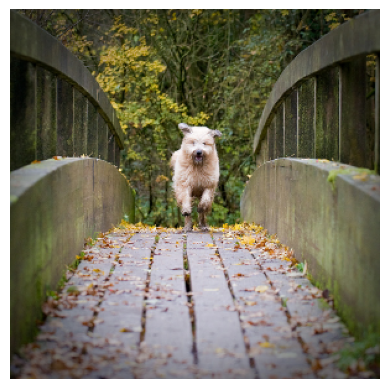

A white dog is running down a path.



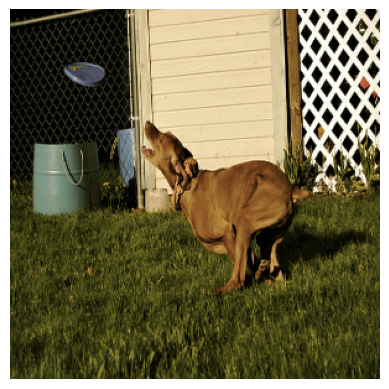

A brown dog is playing in a yard.



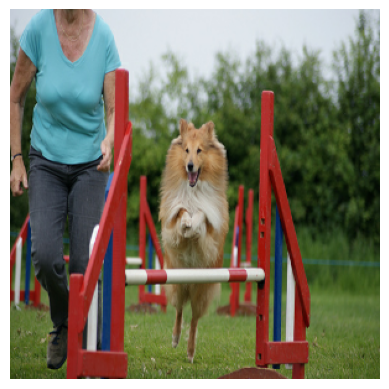

A dog is jumping over a hurdle.



In [47]:
paths = [valid_set_raw[x][0] for x in np.random.randint(0, len(valid_set_raw), size=(3))]

for path in paths:
  generate_text(path)
  print()